In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn.model_selection import train_test_split



# Import Keras
import keras as K
from keras.models import load_model, Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications import Xception, ResNet50V2
from keras.applications.xception import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.losses import CategoricalCrossentropy


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train = unpickle("cifar-100-python\\train")
test = unpickle("cifar-100-python\\test")
meta = unpickle("cifar-100-python\\meta")

In [6]:
print(train[b'data'].shape)

(50000, 3072)


In [6]:
def display_rd_img(dataset):
    load = dataset[b'data']
    num = rd.randint(0, len(load))
    title = str(dataset[b'filenames'][num])
    title = title.split("\'")[1].split("_s_")[0]
    img = load[num]
    img = img.reshape((3,32,32))
    img = img.transpose(1,2,0)
    print(type(img))
    plt.imshow(img)
    plt.title(title)


<class 'numpy.ndarray'>


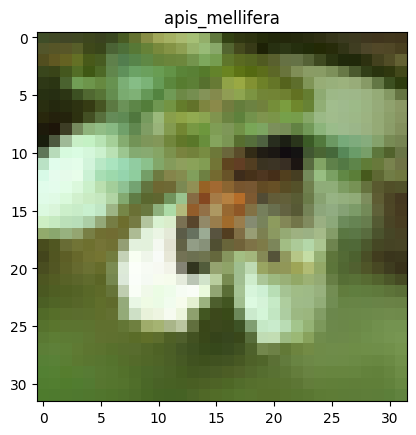

In [7]:
display_rd_img(train)

In [8]:
def pre_process(dataset):
    data = dataset[b'data']
    result = []
    for i in range(0, len(data)):
        temp = data[i].reshape((3,32,32))
        temp= temp.transpose(1,2,0)
        result.append(temp)
    return result

p_train = pre_process(train)    

In [10]:
trained_label = train[b'fine_labels']

In [11]:
print(len(p_train))

50000


In [9]:
class CIFAR100Generator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, shuffle=True, num_classes=100, augment=False):
        self.images = np.array(images, dtype=np.float32) 
        self.labels = np.array(labels, dtype=np.int32)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.augment = augment  # Activation ou non de l'augmentation
        self.indices = np.arange(len(self.images))
        self.images = preprocess_input(self.images)  
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.images) // self.batch_size  # Nombre total de batchs par epoch

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]

        # Convertir les labels en one-hot encoding
        batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)

        # Appliquer l'augmentation uniquement pour l'entraînement
        if self.augment:
            batch_images = self.augment_images(batch_images)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def augment_images(self, batch_images):
        batch_images_aug = []
        for img in batch_images:
            if np.random.rand() > 0.5:  # 50% des images restent inchangées
                batch_images_aug.append(img)
            else:
                img = tf.image.random_flip_left_right(img)
                img = tf.image.random_brightness(img, max_delta=0.2)
                img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
                img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
                img = tf.image.rot90(img, k=np.random.randint(4))
                img = tf.image.resize_with_crop_or_pad(img, 36, 36)
                img = tf.image.random_crop(img, size=[32, 32, 3])
                batch_images_aug.append(img)
        
        return np.array(batch_images_aug, dtype=np.float32)



def create_generators(images, labels, batch_size=32, val_split=0.2):
    """
    Sépare les données en train/val et retourne deux générateurs.
    """
    # Séparation des données en train et validation
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=val_split, random_state=42)

    # Création des générateurs
    train_generator = CIFAR100Generator(X_train, y_train, batch_size=batch_size, shuffle=True, augment=True)  # Augmentation activée
    val_generator = CIFAR100Generator(X_val, y_val, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return train_generator, val_generator



def create_test_generator(images, labels, batch_size=32):
    # Création des générateurs
    test_generator = CIFAR100Generator(images, labels, batch_size=batch_size, shuffle=False, augment=False)  # Pas d'augmentation pour validation
    
    return test_generator


In [13]:
train_generator, val_generator = create_generators(p_train, trained_label, batch_size=64)

In [14]:

x_batch, y_batch = train_generator[0]
print("Shape des images:", x_batch.shape)  # Doit être (batch_size, 32, 32, 3)
print("Shape des labels:", y_batch.shape)  # Doit être (batch_size, 100)


Shape des images: (64, 32, 32, 3)
Shape des labels: (64, 100)


In [15]:
class HardExampleMining(Callback):
    def __init__(self, train_generator, percentile=50):
        super(HardExampleMining, self).__init__()
        self.train_generator = train_generator  # Générateur de données
        self.percentile = percentile  # Seuil pour les hard examples
        self.loss_fn = CategoricalCrossentropy()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🔍 Analyse des hard examples après l'époque {epoch}...")

        X_train, y_train = [], []
        for i in range(len(self.train_generator)):
            X_batch, y_batch = self.train_generator[i]
            X_train.append(X_batch)
            y_train.append(y_batch)

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        y_pred = self.model.predict(X_train, verbose=0)
        losses = K.losses.categorical_crossentropy(y_train, y_pred).numpy()

        # ✅ Correction : Ne pas enlever trop d'exemples
        threshold = np.percentile(losses, self.percentile)
        hard_indices = np.where(losses > threshold)[0]

        # ✅ Si aucun exemple n'est sélectionné, prendre les 10% pires
        if len(hard_indices) == 0:
            hard_indices = np.argsort(losses)[-max(10, len(losses) // 10):]

        print(f"📌 {len(hard_indices)} exemples sélectionnés (seuil = {threshold:.4f})")

        print(f"🔍 Analyse des prédictions après l'époque {epoch}:")
        print(f"  - Probabilité moyenne max : {np.mean(np.max(y_pred, axis=1)):.4f}")
        print(f"  - Écart-type des probas max : {np.std(np.max(y_pred, axis=1)):.4f}")


        plt.hist(losses, bins=30)
        plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
        plt.xlabel("Valeur de la perte")
        plt.ylabel("Nombre d'exemples")
        plt.title("Distribution des pertes")
        plt.show()




In [16]:
def neural_net(num_neurones,num_hidden_layers,dropout_rate, early_stop_patience, lr_scheduler_patience, train_generator,learning_rate= 0.0001):
    base_model = Xception(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    # Ajouter des couches personnalisées
    for _ in range (0, num_hidden_layers): 
        x = Dense(num_neurones, activation='relu')(x)  # Ajouter une couche Dense pour l'apprentissage des caractéristiques
        #x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)  # Ajouter une couche de dropout pour réduire le surapprentissage
    predictions = Dense(100, activation='softmax')(x)  # Couche de sortie pour 100 classes

    # Configurer les callbacks
    checkpoint = ModelCheckpoint("test.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stop_patience, verbose=1, mode='auto')
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=lr_scheduler_patience)
    hardExample = HardExampleMining(train_generator)  # Ajout du callback Hard Example Mining
    callbacks = [checkpoint, early, lr_scheduler, hardExample]

    # Créer l'instance de l'optimiseur avec le learning rate spécifié
    optimizer = Adam(learning_rate=learning_rate)
    #optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)


    # Compiler le modèle avec l'optimiseur configuré
    model = Model(inputs= base_model.input , outputs=predictions)
    model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    return model, callbacks

# Entraîner le modèle
def training(model, cb, n_epoch):
    history = model.fit(
        train_generator,
        epochs=n_epoch,
        validation_data=val_generator,
        callbacks=cb)
    
    model.save('test_final.h5')
    return history

def plot_history(history):
    # Tracer la précision et la perte
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Epoch 1/200
625/625 [==============================] - ETA: 0s - loss: 4.5531 - accuracy: 0.0159
Epoch 1: val_loss improved from inf to 4.79535, saving model to test.h5

🔍 Analyse des hard examples après l'époque 0...
📌 19673 exemples sélectionnés (seuil = 4.6004)
🔍 Analyse des prédictions après l'époque 0:
  - Probabilité moyenne max : 0.0262
  - Écart-type des probas max : 0.0837


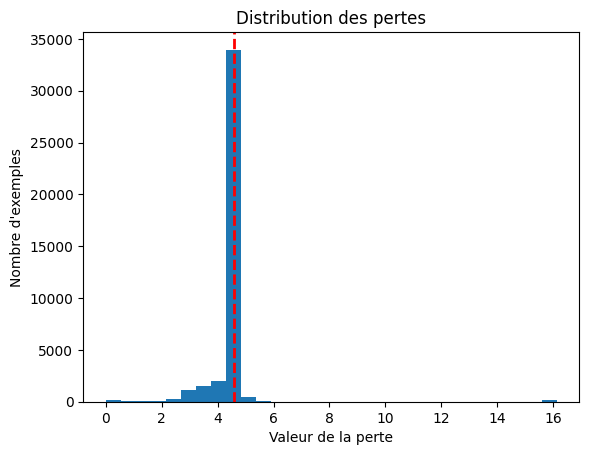

625/625 [==============================] - 211s 326ms/step - loss: 4.5531 - accuracy: 0.0159 - val_loss: 4.7954 - val_accuracy: 0.0405 - lr: 1.0000e-04
Epoch 2/200
625/625 [==============================] - ETA: 0s - loss: 4.3695 - accuracy: 0.0456
Epoch 2: val_loss improved from 4.79535 to 4.20397, saving model to test.h5

🔍 Analyse des hard examples après l'époque 1...
📌 19992 exemples sélectionnés (seuil = 4.5503)
🔍 Analyse des prédictions après l'époque 1:
  - Probabilité moyenne max : 0.0671
  - Écart-type des probas max : 0.1258


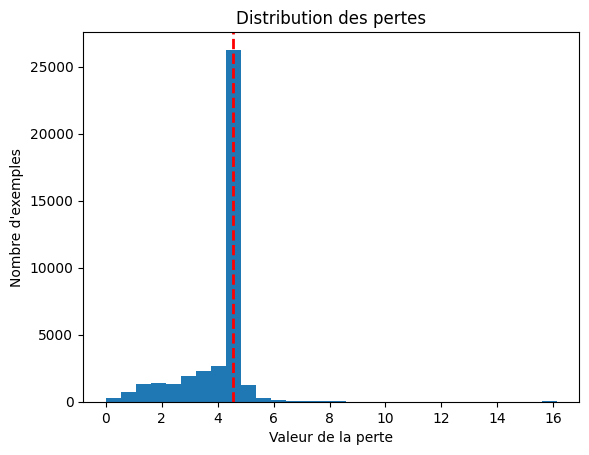

625/625 [==============================] - 201s 322ms/step - loss: 4.3695 - accuracy: 0.0456 - val_loss: 4.2040 - val_accuracy: 0.0996 - lr: 1.0000e-04
Epoch 3/200
625/625 [==============================] - ETA: 0s - loss: 4.0656 - accuracy: 0.1020
Epoch 3: val_loss improved from 4.20397 to 3.62656, saving model to test.h5

🔍 Analyse des hard examples après l'époque 2...
📌 20000 exemples sélectionnés (seuil = 3.9314)
🔍 Analyse des prédictions après l'époque 2:
  - Probabilité moyenne max : 0.1303
  - Écart-type des probas max : 0.1878


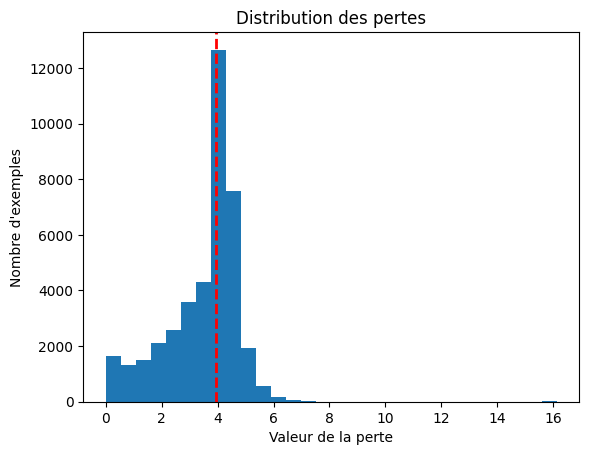

625/625 [==============================] - 201s 322ms/step - loss: 4.0656 - accuracy: 0.1020 - val_loss: 3.6266 - val_accuracy: 0.1738 - lr: 1.0000e-04
Epoch 4/200
625/625 [==============================] - ETA: 0s - loss: 3.7084 - accuracy: 0.1672
Epoch 4: val_loss improved from 3.62656 to 3.31883, saving model to test.h5

🔍 Analyse des hard examples après l'époque 3...
📌 20000 exemples sélectionnés (seuil = 3.4368)
🔍 Analyse des prédictions après l'époque 3:
  - Probabilité moyenne max : 0.1802
  - Écart-type des probas max : 0.2109


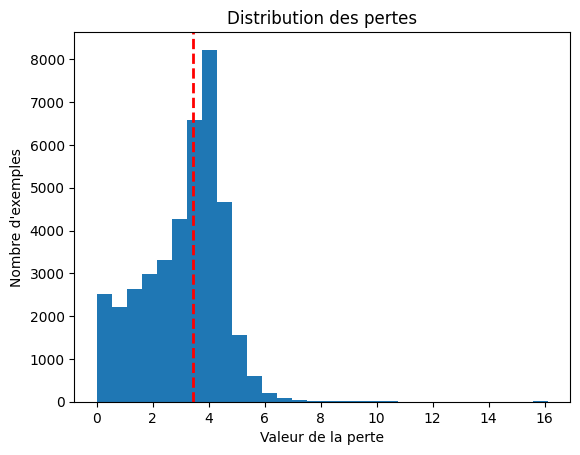

625/625 [==============================] - 202s 323ms/step - loss: 3.7084 - accuracy: 0.1672 - val_loss: 3.3188 - val_accuracy: 0.2561 - lr: 1.0000e-04
Epoch 5/200
625/625 [==============================] - ETA: 0s - loss: 3.4479 - accuracy: 0.2333
Epoch 5: val_loss improved from 3.31883 to 3.03942, saving model to test.h5

🔍 Analyse des hard examples après l'époque 4...
📌 20000 exemples sélectionnés (seuil = 2.9690)
🔍 Analyse des prédictions après l'époque 4:
  - Probabilité moyenne max : 0.2381
  - Écart-type des probas max : 0.2504


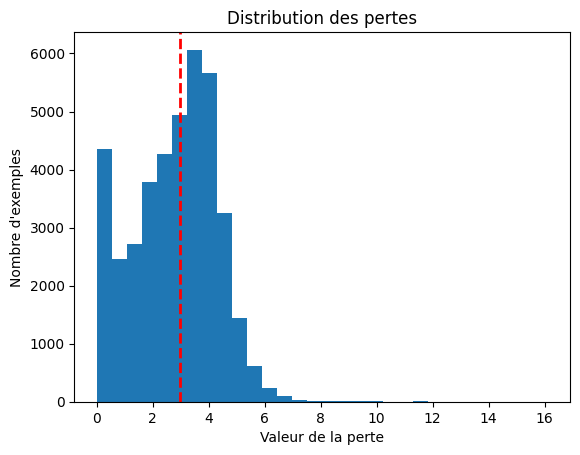

625/625 [==============================] - 204s 326ms/step - loss: 3.4479 - accuracy: 0.2333 - val_loss: 3.0394 - val_accuracy: 0.3212 - lr: 1.0000e-04
Epoch 6/200
625/625 [==============================] - ETA: 0s - loss: 3.2403 - accuracy: 0.2814
Epoch 6: val_loss improved from 3.03942 to 2.87517, saving model to test.h5

🔍 Analyse des hard examples après l'époque 5...
📌 20000 exemples sélectionnés (seuil = 2.5822)
🔍 Analyse des prédictions après l'époque 5:
  - Probabilité moyenne max : 0.2886
  - Écart-type des probas max : 0.2745


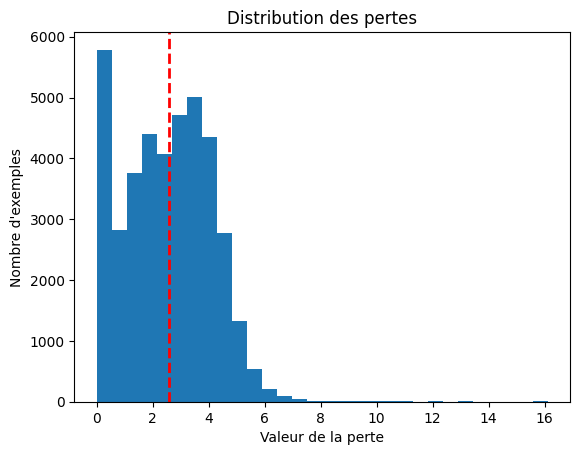

625/625 [==============================] - 204s 326ms/step - loss: 3.2403 - accuracy: 0.2814 - val_loss: 2.8752 - val_accuracy: 0.3758 - lr: 1.0000e-04
Epoch 7/200
625/625 [==============================] - ETA: 0s - loss: 3.0810 - accuracy: 0.3281
Epoch 7: val_loss improved from 2.87517 to 2.71464, saving model to test.h5

🔍 Analyse des hard examples après l'époque 6...
📌 20000 exemples sélectionnés (seuil = 2.2780)
🔍 Analyse des prédictions après l'époque 6:
  - Probabilité moyenne max : 0.3320
  - Écart-type des probas max : 0.2820


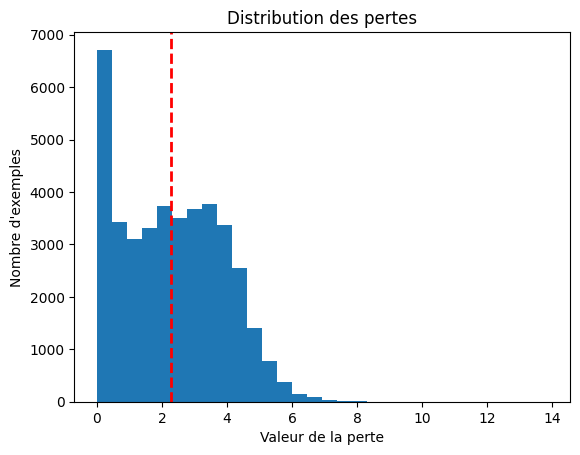

625/625 [==============================] - 205s 328ms/step - loss: 3.0810 - accuracy: 0.3281 - val_loss: 2.7146 - val_accuracy: 0.4103 - lr: 1.0000e-04
Epoch 8/200
625/625 [==============================] - ETA: 0s - loss: 2.9706 - accuracy: 0.3558
Epoch 8: val_loss improved from 2.71464 to 2.67741, saving model to test.h5

🔍 Analyse des hard examples après l'époque 7...
📌 20000 exemples sélectionnés (seuil = 2.0879)
🔍 Analyse des prédictions après l'époque 7:
  - Probabilité moyenne max : 0.3655
  - Écart-type des probas max : 0.2903


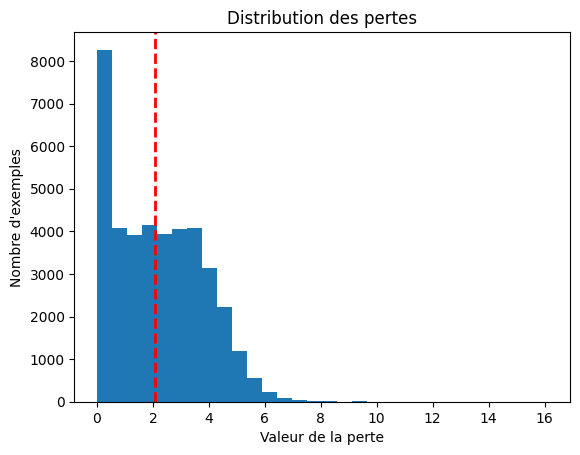

625/625 [==============================] - 213s 341ms/step - loss: 2.9706 - accuracy: 0.3558 - val_loss: 2.6774 - val_accuracy: 0.4281 - lr: 1.0000e-04
Epoch 9/200
625/625 [==============================] - ETA: 0s - loss: 2.8549 - accuracy: 0.3896
Epoch 9: val_loss improved from 2.67741 to 2.58573, saving model to test.h5

🔍 Analyse des hard examples après l'époque 8...
📌 20000 exemples sélectionnés (seuil = 1.8821)
🔍 Analyse des prédictions après l'époque 8:
  - Probabilité moyenne max : 0.3983
  - Écart-type des probas max : 0.3055


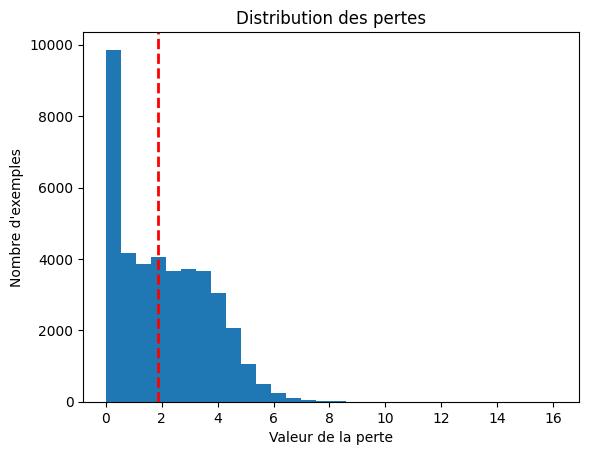

625/625 [==============================] - 190s 304ms/step - loss: 2.8549 - accuracy: 0.3896 - val_loss: 2.5857 - val_accuracy: 0.4566 - lr: 1.0000e-04
Epoch 10/200
625/625 [==============================] - ETA: 0s - loss: 2.7672 - accuracy: 0.4154
Epoch 10: val_loss improved from 2.58573 to 2.51890, saving model to test.h5

🔍 Analyse des hard examples après l'époque 9...
📌 20000 exemples sélectionnés (seuil = 1.7509)
🔍 Analyse des prédictions après l'époque 9:
  - Probabilité moyenne max : 0.4175
  - Écart-type des probas max : 0.3010


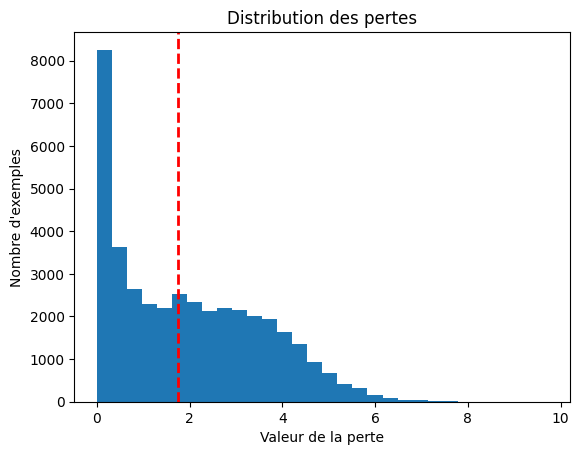

625/625 [==============================] - 216s 346ms/step - loss: 2.7672 - accuracy: 0.4154 - val_loss: 2.5189 - val_accuracy: 0.4744 - lr: 1.0000e-04
Epoch 11/200
625/625 [==============================] - ETA: 0s - loss: 2.6871 - accuracy: 0.4387
Epoch 11: val_loss improved from 2.51890 to 2.51200, saving model to test.h5

🔍 Analyse des hard examples après l'époque 10...
📌 20000 exemples sélectionnés (seuil = 1.6256)
🔍 Analyse des prédictions après l'époque 10:
  - Probabilité moyenne max : 0.4341
  - Écart-type des probas max : 0.3071


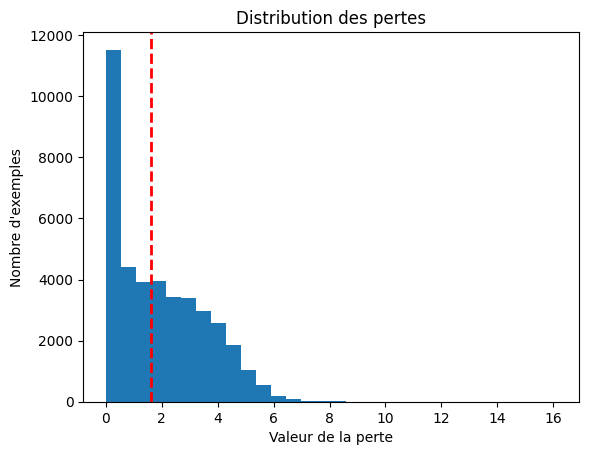

625/625 [==============================] - 219s 351ms/step - loss: 2.6871 - accuracy: 0.4387 - val_loss: 2.5120 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 12/200
625/625 [==============================] - ETA: 0s - loss: 2.6229 - accuracy: 0.4607
Epoch 12: val_loss improved from 2.51200 to 2.46031, saving model to test.h5

🔍 Analyse des hard examples après l'époque 11...
📌 20000 exemples sélectionnés (seuil = 1.4623)
🔍 Analyse des prédictions après l'époque 11:
  - Probabilité moyenne max : 0.4646
  - Écart-type des probas max : 0.3132


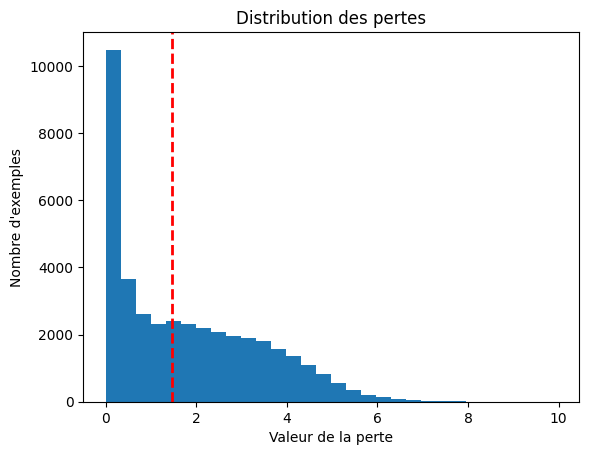

625/625 [==============================] - 220s 352ms/step - loss: 2.6229 - accuracy: 0.4607 - val_loss: 2.4603 - val_accuracy: 0.4957 - lr: 1.0000e-04
Epoch 13/200
625/625 [==============================] - ETA: 0s - loss: 2.5554 - accuracy: 0.4825
Epoch 13: val_loss improved from 2.46031 to 2.42325, saving model to test.h5

🔍 Analyse des hard examples après l'époque 12...
📌 20000 exemples sélectionnés (seuil = 1.2999)
🔍 Analyse des prédictions après l'époque 12:
  - Probabilité moyenne max : 0.4780
  - Écart-type des probas max : 0.3106


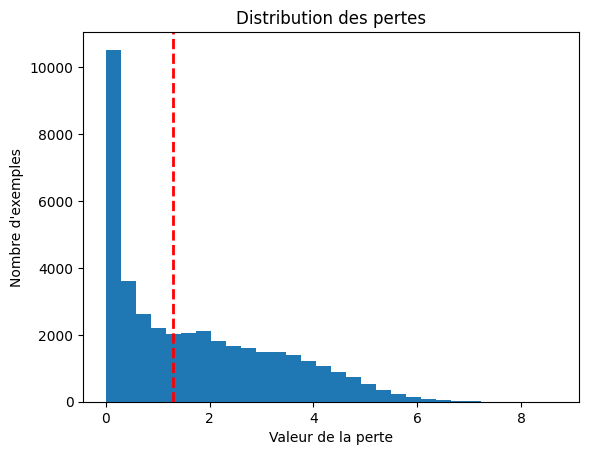

625/625 [==============================] - 221s 354ms/step - loss: 2.5554 - accuracy: 0.4825 - val_loss: 2.4232 - val_accuracy: 0.5042 - lr: 1.0000e-04
Epoch 14/200
625/625 [==============================] - ETA: 0s - loss: 2.4944 - accuracy: 0.4983
Epoch 14: val_loss did not improve from 2.42325

🔍 Analyse des hard examples après l'époque 13...
📌 20000 exemples sélectionnés (seuil = 1.1996)
🔍 Analyse des prédictions après l'époque 13:
  - Probabilité moyenne max : 0.4958
  - Écart-type des probas max : 0.3103


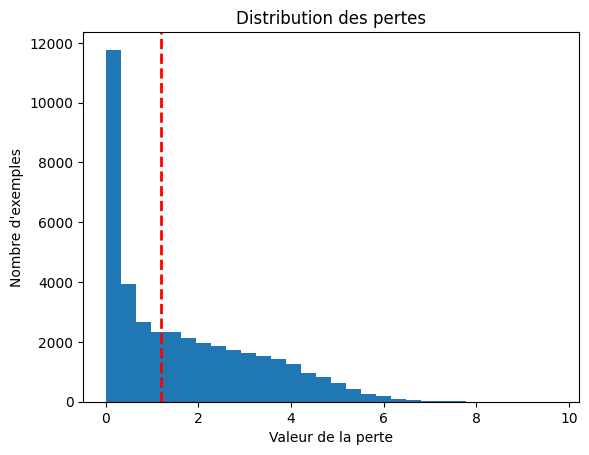

625/625 [==============================] - 232s 371ms/step - loss: 2.4944 - accuracy: 0.4983 - val_loss: 2.4235 - val_accuracy: 0.5050 - lr: 1.0000e-04
Epoch 15/200
625/625 [==============================] - ETA: 0s - loss: 2.4465 - accuracy: 0.5143
Epoch 15: val_loss improved from 2.42325 to 2.37755, saving model to test.h5

🔍 Analyse des hard examples après l'époque 14...
📌 20000 exemples sélectionnés (seuil = 1.0588)
🔍 Analyse des prédictions après l'époque 14:
  - Probabilité moyenne max : 0.5099
  - Écart-type des probas max : 0.3133


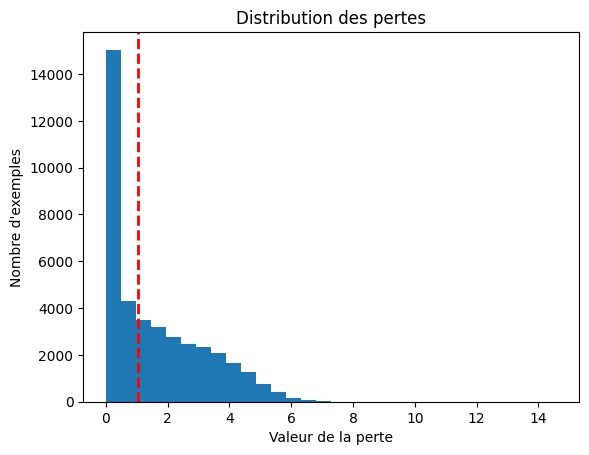

625/625 [==============================] - 219s 351ms/step - loss: 2.4465 - accuracy: 0.5143 - val_loss: 2.3775 - val_accuracy: 0.5199 - lr: 1.0000e-04
Epoch 16/200
625/625 [==============================] - ETA: 0s - loss: 2.3852 - accuracy: 0.5375
Epoch 16: val_loss did not improve from 2.37755

🔍 Analyse des hard examples après l'époque 15...
📌 20000 exemples sélectionnés (seuil = 0.9642)
🔍 Analyse des prédictions après l'époque 15:
  - Probabilité moyenne max : 0.5298
  - Écart-type des probas max : 0.3201


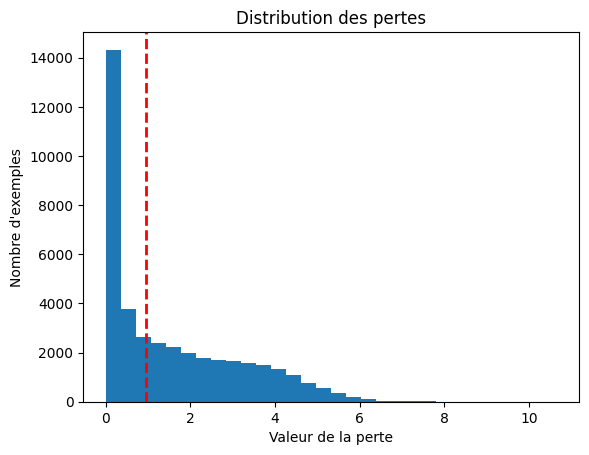

625/625 [==============================] - 215s 344ms/step - loss: 2.3852 - accuracy: 0.5375 - val_loss: 2.3980 - val_accuracy: 0.5178 - lr: 1.0000e-04
Epoch 17/200
625/625 [==============================] - ETA: 0s - loss: 2.3424 - accuracy: 0.5497
Epoch 17: val_loss improved from 2.37755 to 2.37544, saving model to test.h5

🔍 Analyse des hard examples après l'époque 16...
📌 20000 exemples sélectionnés (seuil = 0.7812)
🔍 Analyse des prédictions après l'époque 16:
  - Probabilité moyenne max : 0.5646
  - Écart-type des probas max : 0.3199


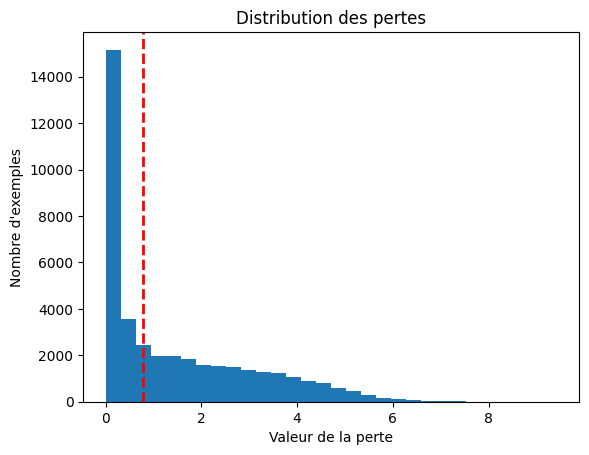

625/625 [==============================] - 203s 324ms/step - loss: 2.3424 - accuracy: 0.5497 - val_loss: 2.3754 - val_accuracy: 0.5241 - lr: 1.0000e-04
Epoch 18/200
625/625 [==============================] - ETA: 0s - loss: 2.2922 - accuracy: 0.5626
Epoch 18: val_loss improved from 2.37544 to 2.36187, saving model to test.h5

🔍 Analyse des hard examples après l'époque 17...
📌 20000 exemples sélectionnés (seuil = 0.7149)
🔍 Analyse des prédictions après l'époque 17:
  - Probabilité moyenne max : 0.5710
  - Écart-type des probas max : 0.3144


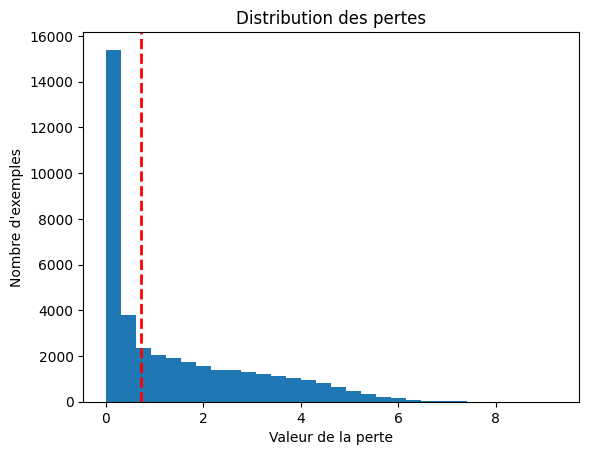

625/625 [==============================] - 220s 352ms/step - loss: 2.2922 - accuracy: 0.5626 - val_loss: 2.3619 - val_accuracy: 0.5310 - lr: 1.0000e-04
Epoch 19/200
625/625 [==============================] - ETA: 0s - loss: 2.2434 - accuracy: 0.5800
Epoch 19: val_loss improved from 2.36187 to 2.34785, saving model to test.h5

🔍 Analyse des hard examples après l'époque 18...
📌 20000 exemples sélectionnés (seuil = 0.6244)
🔍 Analyse des prédictions après l'époque 18:
  - Probabilité moyenne max : 0.5830
  - Écart-type des probas max : 0.3128


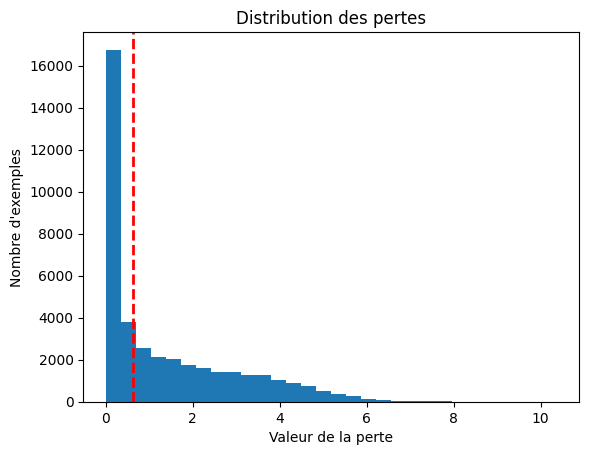

625/625 [==============================] - 213s 341ms/step - loss: 2.2434 - accuracy: 0.5800 - val_loss: 2.3478 - val_accuracy: 0.5408 - lr: 1.0000e-04
Epoch 20/200
625/625 [==============================] - ETA: 0s - loss: 2.2197 - accuracy: 0.5891
Epoch 20: val_loss did not improve from 2.34785

🔍 Analyse des hard examples après l'époque 19...
📌 20000 exemples sélectionnés (seuil = 0.6170)
🔍 Analyse des prédictions après l'époque 19:
  - Probabilité moyenne max : 0.5835
  - Écart-type des probas max : 0.3136


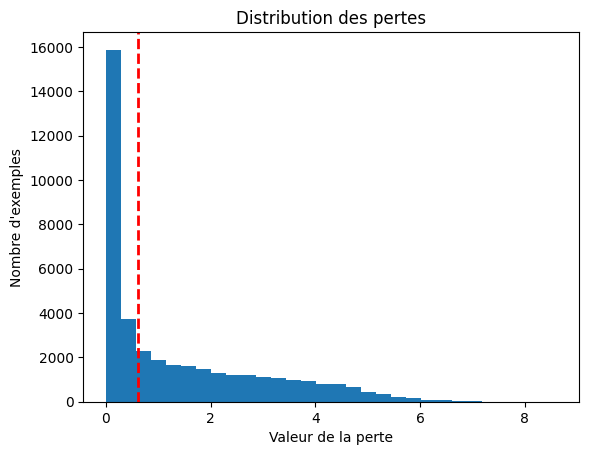

625/625 [==============================] - 195s 312ms/step - loss: 2.2197 - accuracy: 0.5891 - val_loss: 2.3669 - val_accuracy: 0.5382 - lr: 1.0000e-04
Epoch 21/200
625/625 [==============================] - ETA: 0s - loss: 2.1870 - accuracy: 0.5986
Epoch 21: val_loss did not improve from 2.34785

🔍 Analyse des hard examples après l'époque 20...
📌 20000 exemples sélectionnés (seuil = 0.5113)
🔍 Analyse des prédictions après l'époque 20:
  - Probabilité moyenne max : 0.6030
  - Écart-type des probas max : 0.3135


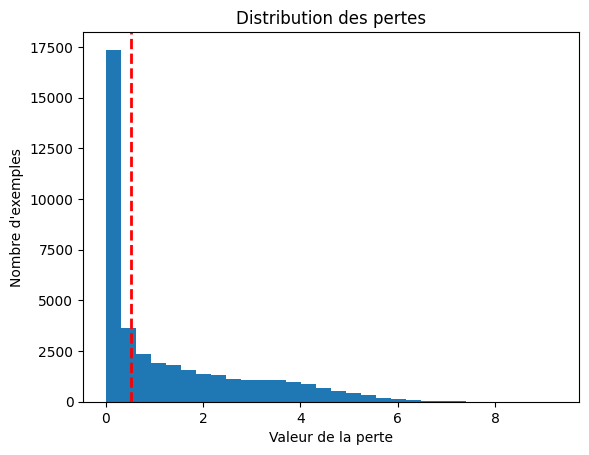

625/625 [==============================] - 195s 313ms/step - loss: 2.1870 - accuracy: 0.5986 - val_loss: 2.3532 - val_accuracy: 0.5443 - lr: 1.0000e-04
Epoch 22/200
625/625 [==============================] - ETA: 0s - loss: 2.1408 - accuracy: 0.6138
Epoch 22: val_loss did not improve from 2.34785

🔍 Analyse des hard examples après l'époque 21...
📌 20000 exemples sélectionnés (seuil = 0.4492)
🔍 Analyse des prédictions après l'époque 21:
  - Probabilité moyenne max : 0.6183
  - Écart-type des probas max : 0.3107


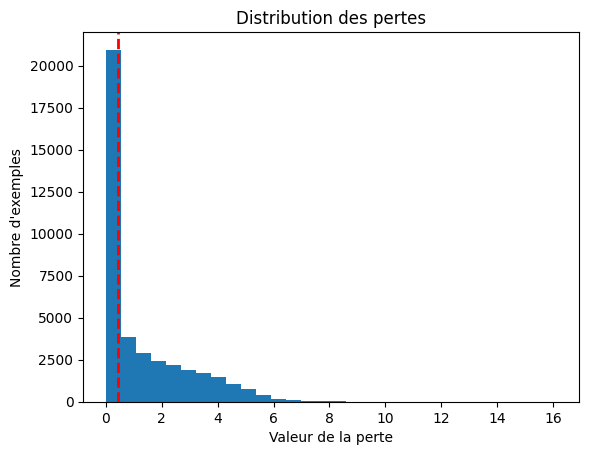

625/625 [==============================] - 195s 313ms/step - loss: 2.1408 - accuracy: 0.6138 - val_loss: 2.3513 - val_accuracy: 0.5489 - lr: 1.0000e-04
Epoch 23/200
625/625 [==============================] - ETA: 0s - loss: 2.0483 - accuracy: 0.6420
Epoch 23: val_loss improved from 2.34785 to 2.29812, saving model to test.h5

🔍 Analyse des hard examples après l'époque 22...
📌 20000 exemples sélectionnés (seuil = 0.3488)
🔍 Analyse des prédictions après l'époque 22:
  - Probabilité moyenne max : 0.6353
  - Écart-type des probas max : 0.3116


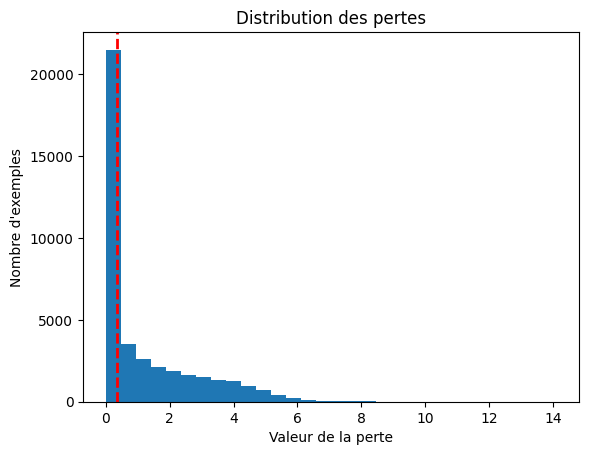

625/625 [==============================] - 195s 312ms/step - loss: 2.0483 - accuracy: 0.6420 - val_loss: 2.2981 - val_accuracy: 0.5627 - lr: 1.0000e-05
Epoch 24/200
625/625 [==============================] - ETA: 0s - loss: 2.0170 - accuracy: 0.6544
Epoch 24: val_loss did not improve from 2.29812

🔍 Analyse des hard examples après l'époque 23...
📌 20000 exemples sélectionnés (seuil = 0.3103)
🔍 Analyse des prédictions après l'époque 23:
  - Probabilité moyenne max : 0.6442
  - Écart-type des probas max : 0.3108


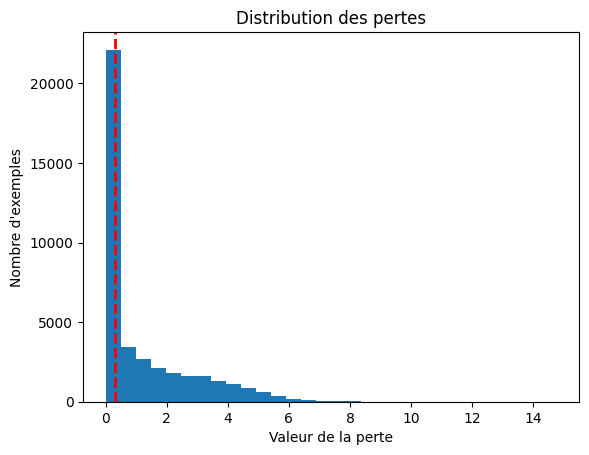

625/625 [==============================] - 194s 311ms/step - loss: 2.0170 - accuracy: 0.6544 - val_loss: 2.3041 - val_accuracy: 0.5641 - lr: 1.0000e-05
Epoch 25/200
625/625 [==============================] - ETA: 0s - loss: 1.9980 - accuracy: 0.6579
Epoch 25: val_loss improved from 2.29812 to 2.28543, saving model to test.h5

🔍 Analyse des hard examples après l'époque 24...
📌 20000 exemples sélectionnés (seuil = 0.2939)
🔍 Analyse des prédictions après l'époque 24:
  - Probabilité moyenne max : 0.6476
  - Écart-type des probas max : 0.3101


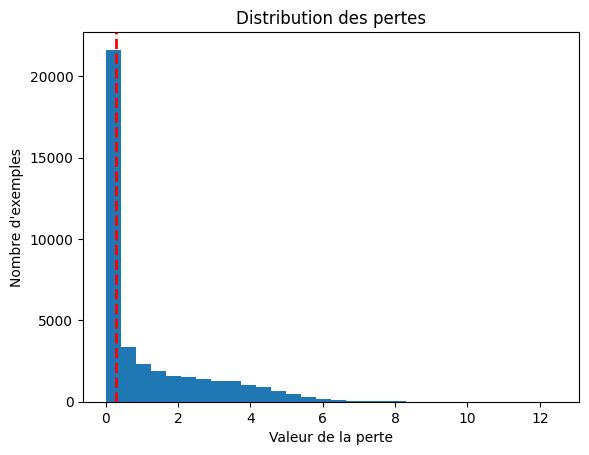

625/625 [==============================] - 194s 311ms/step - loss: 1.9980 - accuracy: 0.6579 - val_loss: 2.2854 - val_accuracy: 0.5694 - lr: 1.0000e-05
Epoch 26/200
625/625 [==============================] - ETA: 0s - loss: 1.9865 - accuracy: 0.6619
Epoch 26: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 25...
📌 20000 exemples sélectionnés (seuil = 0.2739)
🔍 Analyse des prédictions après l'époque 25:
  - Probabilité moyenne max : 0.6522
  - Écart-type des probas max : 0.3095


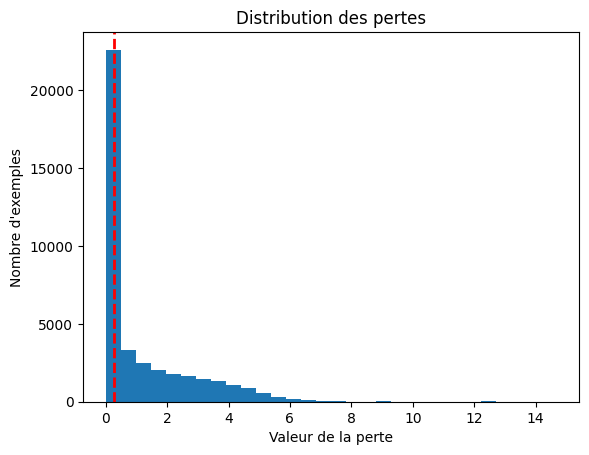

625/625 [==============================] - 191s 306ms/step - loss: 1.9865 - accuracy: 0.6619 - val_loss: 2.3059 - val_accuracy: 0.5652 - lr: 1.0000e-05
Epoch 27/200
625/625 [==============================] - ETA: 0s - loss: 1.9659 - accuracy: 0.6670
Epoch 27: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 26...
📌 20000 exemples sélectionnés (seuil = 0.2623)
🔍 Analyse des prédictions après l'époque 26:
  - Probabilité moyenne max : 0.6580
  - Écart-type des probas max : 0.3065


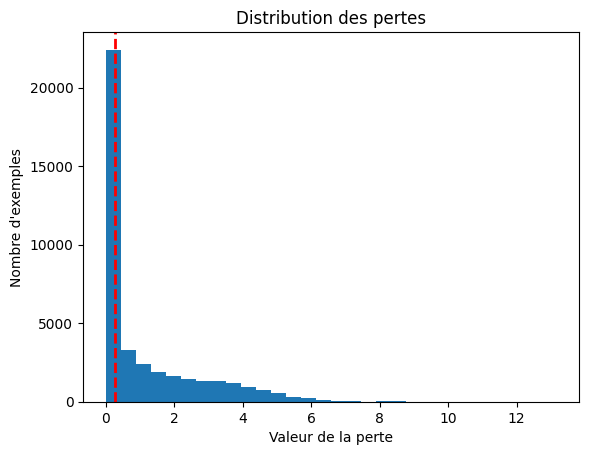

625/625 [==============================] - 191s 305ms/step - loss: 1.9659 - accuracy: 0.6670 - val_loss: 2.2969 - val_accuracy: 0.5666 - lr: 1.0000e-05
Epoch 28/200
625/625 [==============================] - ETA: 0s - loss: 1.9586 - accuracy: 0.6714
Epoch 28: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 27...
📌 20000 exemples sélectionnés (seuil = 0.2552)
🔍 Analyse des prédictions après l'époque 27:
  - Probabilité moyenne max : 0.6591
  - Écart-type des probas max : 0.3087


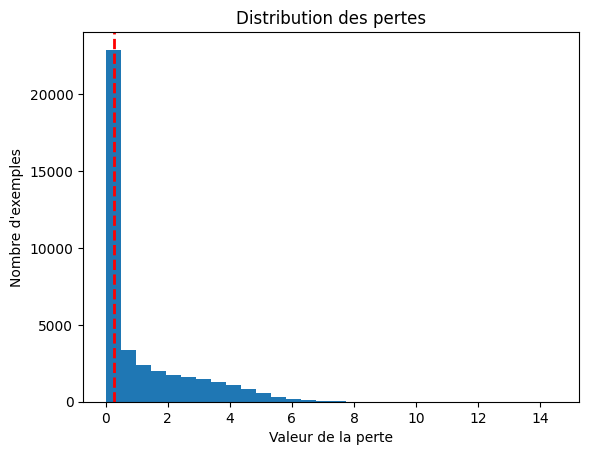

625/625 [==============================] - 191s 306ms/step - loss: 1.9586 - accuracy: 0.6714 - val_loss: 2.2900 - val_accuracy: 0.5697 - lr: 1.0000e-05
Epoch 29/200
625/625 [==============================] - ETA: 0s - loss: 1.9506 - accuracy: 0.6745
Epoch 29: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 28...
📌 20000 exemples sélectionnés (seuil = 0.2544)
🔍 Analyse des prédictions après l'époque 28:
  - Probabilité moyenne max : 0.6605
  - Écart-type des probas max : 0.3072


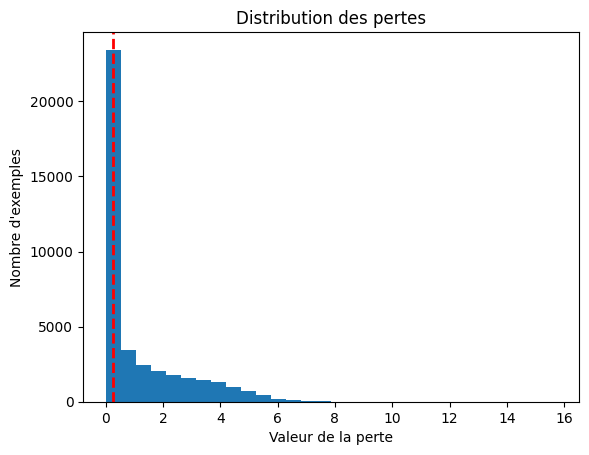

625/625 [==============================] - 193s 309ms/step - loss: 1.9506 - accuracy: 0.6745 - val_loss: 2.2928 - val_accuracy: 0.5708 - lr: 1.0000e-06
Epoch 30/200
625/625 [==============================] - ETA: 0s - loss: 1.9378 - accuracy: 0.6795
Epoch 30: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 29...
📌 20000 exemples sélectionnés (seuil = 0.2496)
🔍 Analyse des prédictions après l'époque 29:
  - Probabilité moyenne max : 0.6606
  - Écart-type des probas max : 0.3075


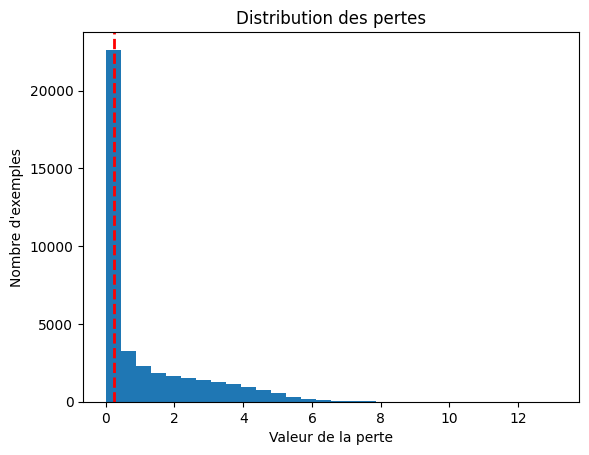

625/625 [==============================] - 194s 311ms/step - loss: 1.9378 - accuracy: 0.6795 - val_loss: 2.2895 - val_accuracy: 0.5699 - lr: 1.0000e-06
Epoch 31/200
625/625 [==============================] - ETA: 0s - loss: 1.9426 - accuracy: 0.6747
Epoch 31: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 30...
📌 20000 exemples sélectionnés (seuil = 0.2500)
🔍 Analyse des prédictions après l'époque 30:
  - Probabilité moyenne max : 0.6624
  - Écart-type des probas max : 0.3069


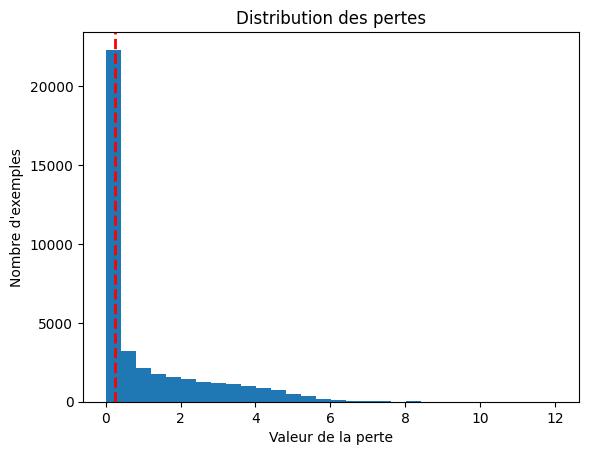

625/625 [==============================] - 192s 308ms/step - loss: 1.9426 - accuracy: 0.6747 - val_loss: 2.2859 - val_accuracy: 0.5701 - lr: 1.0000e-06
Epoch 32/200
625/625 [==============================] - ETA: 0s - loss: 1.9416 - accuracy: 0.6769
Epoch 32: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 31...
📌 20000 exemples sélectionnés (seuil = 0.2517)
🔍 Analyse des prédictions après l'époque 31:
  - Probabilité moyenne max : 0.6597
  - Écart-type des probas max : 0.3073


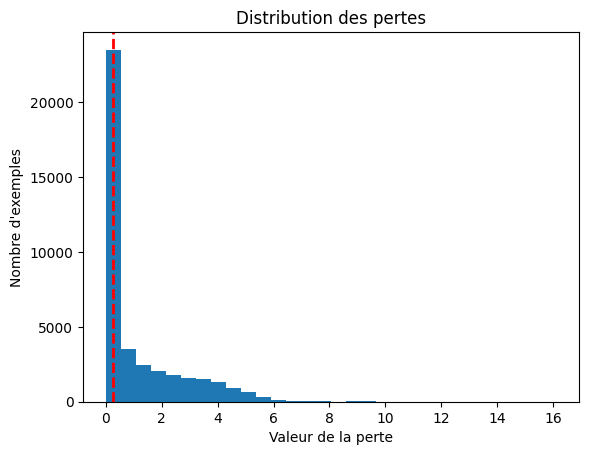

625/625 [==============================] - 192s 307ms/step - loss: 1.9416 - accuracy: 0.6769 - val_loss: 2.2908 - val_accuracy: 0.5714 - lr: 1.0000e-07
Epoch 33/200
625/625 [==============================] - ETA: 0s - loss: 1.9391 - accuracy: 0.6753
Epoch 33: val_loss did not improve from 2.28543

🔍 Analyse des hard examples après l'époque 32...
📌 20000 exemples sélectionnés (seuil = 0.2416)
🔍 Analyse des prédictions après l'époque 32:
  - Probabilité moyenne max : 0.6631
  - Écart-type des probas max : 0.3069


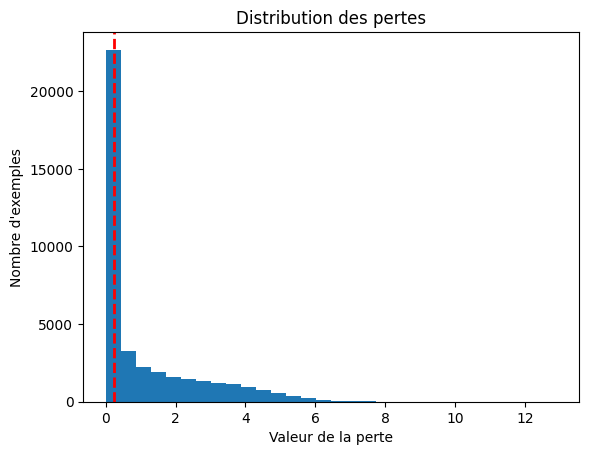

625/625 [==============================] - 200s 320ms/step - loss: 1.9391 - accuracy: 0.6753 - val_loss: 2.2922 - val_accuracy: 0.5703 - lr: 1.0000e-07
Epoch 33: early stopping


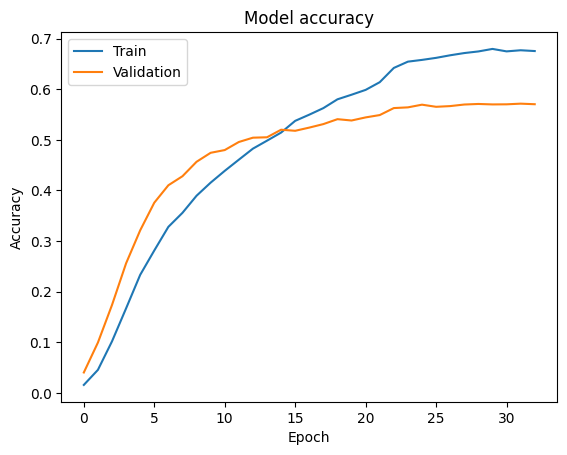

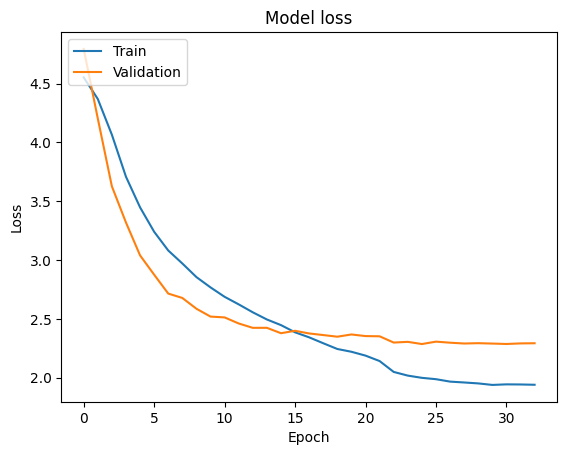

In [17]:
model, callback = neural_net(num_neurones=512, num_hidden_layers=3, 
                            dropout_rate=0.4, early_stop_patience=8, 
                            lr_scheduler_patience=3, train_generator=train_generator,
                            learning_rate= 0.0001)

history = training(model=model, cb= callback, n_epoch=200)

plot_history(history=history)

In [10]:
p_test = pre_process(test)
test_labels = test[b'fine_labels']

In [11]:
test_generator = create_test_generator(p_test, test_labels, batch_size=64)

In [14]:
model = load_model("test_final.h5")

In [15]:
model.evaluate(test_generator)

156/156 [==============================] - 3s 11ms/step - loss: 2.2806 - accuracy: 0.5603


[2.280637741088867, 0.5602964758872986]